In [ ]:
pip install opencv-python
pip install pupil-apriltags 
pip install pyyaml
pip install matplotlib

In [ ]:
from platform import python_version
print(python_version())
# 3.7.16 works for pupil apriltag library

<IPython.core.display.Javascript object>


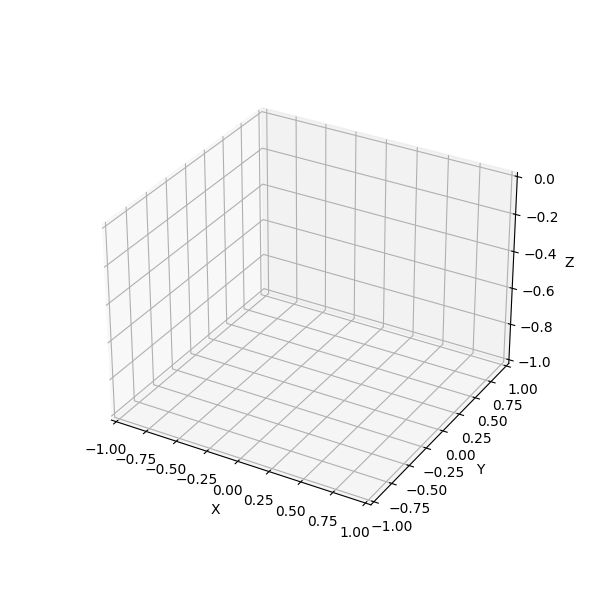

In [3]:
# Drone Coordinate System: +X towards front of drone, +Y towards right of drone, +Z towards ground
# Apriltag Coordinate System: +X towards right of tag, +Y towards top of tag, +Z further from tag
# Desired Coordinate System: origin at drone camera, coordinate rotation same as apriltag coordinate system but rotated about tag z axis to align yaw with drone
# Note that zero yaw occurs when xy of drone and apriltag coordinate systems align

import cv2
import os
from pupil_apriltags import Detector
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

# Camera Calibration Data
# Kohya's Laptop
fxcal = 938.61258241
fycal = 937.70826823
cxcal = 669.06224346
cycal = 379.28535514
tag_size = .1075
cap = cv2.VideoCapture(0) # webcam reference
cap.set(3, 1280)
cap.set(4, 720)
    
i = 0

# Check if opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# Set Up Plot
plt.ion()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z') 
ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-1, top=0)
fig.show()
    
while (cap.isOpened()):
    ret, frame = cap.read() # ret = bool for capture success, if success is stored in frame
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA) # frame is each image from webcam

    gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
   
    # initialize detector
    at_detector = Detector(
        families="tag36h11",
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0
    )

    tags = at_detector.detect(gray_img, estimate_tag_pose=True, camera_params=(fxcal, fycal, cxcal, cycal), tag_size=tag_size)
    for tag in tags:
        pose_r = tag.pose_R
        pose_t = -tag.pose_t
        homography = tag.homography
        pitch = np.arcsin(-pose_r[2,0]) # pitch dependent on tag orientation
        roll = np.arcsin(pose_r[2,1]/np.cos(pitch)) # roll depedent on tag orientation
        yaw = np.arcsin(pose_r[1,0]/np.cos(pitch))

        
#         Print and plot apriltag position with drone as origin
        print('x: ', np.round(pose_t[0],2), 'y: ', np.round(pose_t[1],2), 'z: ', np.round(pose_t[2],2), 'yaw: ', np.round(yaw,2), 'pitch: ', np.round(pitch,2),'roll: ', np.round(roll,2), end='\r')
        xrot = pose_r*np.array([.25, 0, 0]).reshape(1,-1)
        yrot = pose_r*np.array([0, .25, 0]).reshape(1,-1)
        zrot = pose_r*np.array([0, 0, .25]).reshape(1,-1)
        xcoord = ax.plot3D([np.squeeze(pose_t[0]), np.squeeze(pose_t[0]+xrot[0,0])],[np.squeeze(pose_t[1]), np.squeeze(pose_t[1]+xrot[1,0])], [np.squeeze(pose_t[2]), np.squeeze(pose_t[2]+xrot[2,0])], 'red')
        ycoord = ax.plot3D([np.squeeze(pose_t[0]), np.squeeze(pose_t[0]+yrot[0,1])],[np.squeeze(pose_t[1]), np.squeeze(pose_t[1]+yrot[1,1])], [np.squeeze(pose_t[2]), np.squeeze(pose_t[2]+yrot[2,1])], 'green')
        zcoord = ax.plot3D([np.squeeze(pose_t[0]), np.squeeze(pose_t[0]+zrot[0,2])],[np.squeeze(pose_t[1]), np.squeeze(pose_t[1]+zrot[1,2])], [np.squeeze(pose_t[2]), np.squeeze(pose_t[2]+zrot[2,2])], 'blue')
        f = ax.scatter3D(pose_t[0], pose_t[1], pose_t[2], color='blue')
        fig.canvas.draw()
        xrem = xcoord.pop(0)
        xrem.remove()
        yrem = ycoord.pop(0)
        yrem.remove()
        zrem = zcoord.pop(0)
        zrem.remove()
        f.remove()
    
#         Calculate, print, and plot the drone position with apriltag as origin
#         arr1 = np.array(pose_r)
#         cpose_r = np.linalg.inv(arr1)
#         cpose_t = np.array(-1*pose_t)
#         tframepose_t = np.matmul(cpose_r, cpose_t)
#         print('x: ', tframepose_t[0], 'y: ', tframepose_t[1], 'z: ', tframepose_t[2], end='\r')
#         f = ax.scatter3D(tframepose_t[0], tframepose_t[1], tframepose_t[2], color='blue')
#         fig.canvas.draw()
#         f.remove()


#         Calculate, print, and plot the apriltag position with camera as origin, but with apriltag coordinate system rotated to align with drone yaw
#         arr1 = np.array(pose_r)
#         cpose_r = np.linalg.inv(arr1)
#         cpose_t = np.array(-1*pose_t)
#         tframepose_t = np.matmul(cpose_r, cpose_t)
#         cframepose_t = -tframepose_t # Transfer origin back to drone
#         yawarray = np.array([[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]) # define rotation matrix
#         position = np.matmul(np.linalg.inv(yawarray), cframepose_t)
#         print('x: ', position[0], 'y: ', position[1], 'z: ', position[2], 'yaw: ', -yaw, end='\r')
#         f = ax.scatter3D(position[0], position[1], position[2], color='blue')
#         fig.canvas.draw()
#         f.remove()
    
    tags = at_detector.detect(gray_img)
    for tag in tags:
#         print(int(tag.center[0]),int(tag.center[1]))
        detected_img = cv2.circle(gray_img, (int(tag.center[0]),int(tag.center[1])), radius=5, color=(200,200,200), thickness=2)
        for corner in tag.corners:
            detected_img = cv2.circle(gray_img, (int(corner[0]), int(corner[1])),radius=5, color=(0,255,0), thickness=2)    
    
#     for troubleshooting display on laptop    
    if type(detected_img) == np.ndarray:
        cv2.imshow("Filtered: Ecs to exit", detected_img)
        save_img = detected_img
    else:
        cv2.imshow("Filtered: Ecs to exit", frame)
        save_img = frame
    detected_img = frame; # reset img definition
        
#     Press 'q' to end script
    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break
        
    # writes to folder on desktop, rename as required 
#     cv2.imwrite(os.path.join("C:\\Users\\katok\\OneDrive\\Desktop\\ME 495\\AprilTag",'Frame'+str(i)+'.jpg'), save_img) 
#     i += 1
    
cap.release()
cv2.destroyAllWindows()